In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import os

In [22]:
# Read the CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [23]:
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
testDF = df_encoded
print(df_encoded['diabetes'].value_counts())

0    91500
1     8500
Name: diabetes, dtype: int64


In [24]:
testDF = testDF.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
boolean_columns = x_unscaled.select_dtypes(include=bool).columns

scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

## Testing the MLP Model

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error

# Check if CUDA is available and print the device being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 1)
#         )

#     def forward(self, x):
#         return self.model(x)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Sigmoid for binary classification
        )
        
    def forward(self, x):
        return self.model(x)

# Define input dimensions and load the model
input_dim = x_scaled.shape[1]
model = MLP(input_dim).to(device)

# Load the saved model
model_file = './models/mlp_model_resampled_0.1.pth'
if os.path.exists(model_file):
    model.load_state_dict(torch.load(model_file))
    print("Model loaded successfully.")
else:
    print("Model file does not exist.")
    raise FileNotFoundError("Model file not found.")

# Convert x_scaled to a torch tensor
x_scaled_tensor = torch.tensor(x_scaled.values, dtype=torch.float32).to(device)

# Make predictions on the entire dataset
model.eval()
with torch.no_grad():
    y_pred = model(x_scaled_tensor).cpu().numpy()

# Calculate the Mean Squared Error (MSE) on the entire dataset
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on Entire Dataset: {rmse}')

# Convert y_pred to binary predictions
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Ensure y is a numpy array and reshape if necessary
y_array = y.values if hasattr(y, 'values') else y
if y_array.ndim > 1:
    y_array = y_array.reshape(-1)

# Ensure y_pred_binary is a 1-dimensional array
if y_pred_binary.ndim > 1:
    y_pred_binary = y_pred_binary.reshape(-1)

# Compare y_pred_binary with y
correct_predictions = np.sum(y_pred_binary == y_array)
wrong_predictions = np.sum(y_pred_binary != y_array)

# Track indices of wrong predictions
wrong_prediction_indices = np.where(y_pred_binary != y_array)[0]

# Calculate additional metrics
true_positives = np.sum((y_pred_binary == 1) & (y_array == 1))
true_negatives = np.sum((y_pred_binary == 0) & (y_array == 0))
false_positives = np.sum((y_pred_binary == 1) & (y_array == 0))
false_negatives = np.sum((y_pred_binary == 0) & (y_array == 1))

print(f"Number of Correct Predictions: {correct_predictions}")
print(f"Number of Wrong Predictions: {wrong_predictions}")
print(f"Accuracy: {correct_predictions / len(y_array):.4f}")
print(f"Number of True Positives (1 predicted as 1): {true_positives}")
print(f"Number of True Negatives (0 predicted as 0): {true_negatives}")
print(f"Number of False Positives (0 predicted as 1): {false_positives}")
print(f"Number of False Negatives (1 predicted as 0): {false_negatives}")

# Evaluate the model on the test set
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Create DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = nn.MSELoss()(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Calculate Mean Absolute Error (MAE) on the test set
test_mae = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        test_mae += mae.item() * X_batch.size(0)

test_mae /= len(test_loader.dataset)
print(f'Test MAE: {test_mae:.4f}')

Using device: cuda
Model loaded successfully.
Root Mean Squared Error on Entire Dataset: 0.16171582621839936
Number of Correct Predictions: 96849
Number of Wrong Predictions: 3151
Accuracy: 0.9685
Number of True Positives (1 predicted as 1): 5772
Number of True Negatives (0 predicted as 0): 91077
Number of False Positives (0 predicted as 1): 423
Number of False Negatives (1 predicted as 0): 2728


C:\Users\ROG\AppData\Local\Temp/ipykernel_19460/4129066598.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


Test Loss: 0.0264
Test MAE: 0.0436


In [26]:
print("Indices of Wrong Predictions:", wrong_prediction_indices)

Indices of Wrong Predictions: [   43   125   147 ... 99743 99773 99893]


## Testing the autoencoder model

In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Check if CUDA is available and print the device being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, encoding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Define the Decoder model with reduced complexity and dropout
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.decoder(x)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define input dimensions and encoding dimensions
input_dim = x_scaled.shape[1]  # Set this to the number of features in your data
encoding_dim = 8

# Model file paths
encoder_model_file = './models/encoder3.pth'
decoder_model_file = './models/decoder3.pth'

# Load the encoder and decoder models
encoder = Encoder(input_dim, encoding_dim).to(device)
decoder = Decoder(encoding_dim, input_dim).to(device)

encoder.load_state_dict(torch.load(encoder_model_file))
decoder.load_state_dict(torch.load(decoder_model_file))

encoder.eval()
decoder.eval()

# Combine Encoder and Decoder to form the Autoencoder
autoencoder = Autoencoder(encoder, decoder).to(device)
autoencoder.eval()

# Convert x_scaled to a torch tensor
x_scaled = x_scaled.values 
x_scaled_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)

# Reconstruct x_scaled using the autoencoder
with torch.no_grad():
    x_reconstructed = autoencoder(x_scaled_tensor).cpu().numpy()

# Calculate Mean Squared Error (MSE)
mse = np.mean((x_scaled - x_reconstructed) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(x_scaled - x_reconstructed))
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Reconstruction Error Percentage
# reconstruction_error = np.mean(np.square(x_scaled - x_reconstructed), axis=1)
reconstruction_error = np.mean(np.abs(x_scaled - x_reconstructed) / (np.abs(x_scaled) + 1e-8), axis=1)
reconstruction_error_percentage = np.mean(reconstruction_error) * 100
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage:.2f}%')

# Define thresholds in 0.5% intervals up to 10%
thresholds = np.arange(0.5, 50, 1)

# Store the number of samples with errors exceeding thresholds
error_counts = {threshold: np.sum(reconstruction_error * 100 > threshold) for threshold in thresholds}

# Print the number of samples with errors exceeding each threshold
for threshold, count in error_counts.items():
    print("Number of samples with error less than {:.2f}%: {}".format(threshold, len(reconstruction_error) - count))

Using device: cuda
Mean Squared Error (MSE): 0.017146976364802783
Mean Absolute Error (MAE): 0.06256898621690399
Reconstruction Error Percentage: 1677.88%
Number of samples with error less than 0.50%: 0
Number of samples with error less than 1.50%: 0
Number of samples with error less than 2.50%: 3
Number of samples with error less than 3.50%: 40
Number of samples with error less than 4.50%: 431
Number of samples with error less than 5.50%: 1861
Number of samples with error less than 6.50%: 4500
Number of samples with error less than 7.50%: 7857
Number of samples with error less than 8.50%: 11502
Number of samples with error less than 9.50%: 15583
Number of samples with error less than 10.50%: 19806
Number of samples with error less than 11.50%: 23761
Number of samples with error less than 12.50%: 27630
Number of samples with error less than 13.50%: 31358
Number of samples with error less than 14.50%: 35034
Number of samples with error less than 15.50%: 38350
Number of samples with erro

C:\Users\ROG\AppData\Local\Temp/ipykernel_19460/3263076867.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_model_file))
C:\Us

In [28]:
# Find indices with over 2.5% reconstruction error
high_error_indices = np.where(reconstruction_error * 100 > 50)[0]

# Find the overlap between wrong_prediction_indices and high_error_indices
overlap_indices = np.intersect1d(wrong_prediction_indices, high_error_indices)

print(f"Number of overlapping indices: {len(overlap_indices)}")
print("Overlapping indices:", overlap_indices)
print("Number of high erorr indices:", len(high_error_indices))

Number of overlapping indices: 843
Overlapping indices: [  125   168   233   342   381   403   636   664  1321  1340  1697  1836
  1933  2015  2239  2278  2333  2346  2824  3005  3045  3287  3322  3365
  3395  3601  3619  3623  3702  3827  3909  4075  4210  4569  4624  4750
  4818  4835  4914  4969  5003  5198  5619  5808  5886  6204  6348  6378
  6387  6895  7008  7027  7120  7238  7265  7600  7602  7658  7882  8088
  8216  8281  8358  8370  8375  8464  8700  8960  8969  9003  9400  9553
  9658  9879  9885  9886  9968 10019 10269 10333 10439 10643 10847 10878
 10888 10906 11215 11225 11233 11525 11552 11632 11635 11695 11782 11808
 11828 11894 11913 12018 12043 12109 12122 12157 12294 12364 12468 12622
 12721 12764 12805 12844 13151 13324 13401 13711 13755 13793 13944 13983
 14179 14223 14436 14487 14724 14791 14880 15209 15570 15575 15675 15818
 15824 15975 15987 16145 16314 16318 16343 16384 16495 16549 16572 16837
 16869 16988 17244 17288 17485 17883 17948 18063 18278 18334 18499 1

Reconstruction Errors for Wrong Predictions: [0.20849581 0.03733496 0.07121358 0.03857245 0.11182235 0.03811714
 0.03949603 0.0419127  0.04666793 0.06412664 0.04418756 0.05792129
 0.29492117 0.23986016 0.20994068 0.16059295 0.04439385 0.07647936
 0.15933518 0.03798826 0.41804346 0.03658658 0.06639114 0.0689923
 0.05025266 0.04148577 0.09508559 0.03845274 0.04467931 0.03897079
 0.08723148 0.03880614 0.06592335 0.08792321 0.0456458  0.04952434
 0.0609229  0.10942505 0.04188479 0.1455628  0.04137471 0.04684294
 0.24496666 0.04184267 0.19615995 0.04361436 0.09483686 0.11401338
 0.14552829 0.04961072 0.09098231 0.08664512 0.05014641 0.06391387
 0.04092034 0.04261183 0.14650952 0.13678848 0.03689278 0.0852201
 0.03866581 0.08833567 0.03807764 0.0886689  0.09148905 0.03801572
 0.04349972 0.05061264 0.04545931 0.07845995 0.04693983 0.09862357
 0.04588798 0.04286709 0.08015965 0.06088959 0.04890357 0.07052018
 0.05780801 0.045616   0.14256126 0.03912674 0.24803772 0.04554611
 0.05305271 0.12156

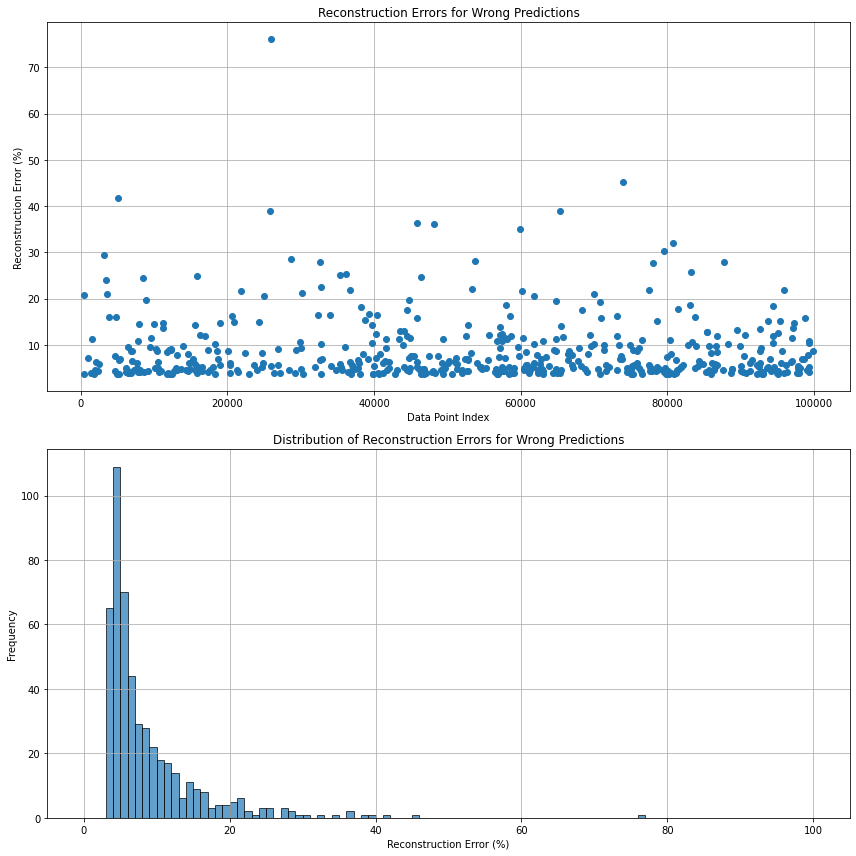

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming autoencoder is your trained model and x_scaled is your test data
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(x_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# Calculate reconstruction errors
reconstruction_error = np.mean(np.square(x_scaled - reconstructed_test), axis=1)

# Define the threshold for reconstruction error
threshold = 3.62 / 100  # Convert percentage to a fraction

# Identify indices with reconstruction error above the threshold
high_error_indices = np.where(reconstruction_error > threshold)[0]

# Assuming wrong_prediction_indices is already defined
# Find the overlap between high error indices and wrong prediction indices
overlap_indices = np.intersect1d(high_error_indices, wrong_prediction_indices)

# Filter the reconstruction errors for the overlapping indices
wrong_prediction_reconstruction_errors = reconstruction_error[overlap_indices]

# Ensure that all filtered reconstruction errors are above the threshold
assert np.all(wrong_prediction_reconstruction_errors > threshold), "Some reconstruction errors are below the threshold"

# Print the reconstruction errors for the wrong prediction indices
print("Reconstruction Errors for Wrong Predictions:", wrong_prediction_reconstruction_errors)

# Optionally, you can calculate some statistics like mean and standard deviation
mean_error = np.mean(wrong_prediction_reconstruction_errors)
std_error = np.std(wrong_prediction_reconstruction_errors)

print(f"Mean Reconstruction Error for Wrong Predictions: {mean_error * 100:.2f}%")
print(f"Standard Deviation of Reconstruction Error for Wrong Predictions: {std_error * 100:.2f}%")
print("Number of overlapping indices:", len(overlap_indices))

# Plot the reconstruction errors for the wrong prediction indices
plt.figure(figsize=(12, 12))

# First subplot: Reconstruction errors for wrong prediction indices
plt.subplot(2, 1, 1)
plt.plot(overlap_indices, wrong_prediction_reconstruction_errors * 100, marker='o', linestyle='none')
plt.title('Reconstruction Errors for Wrong Predictions')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error (%)')
plt.grid(True)

# Second subplot: Distribution of reconstruction errors for wrong prediction indices
plt.subplot(2, 1, 2)
wrong_prediction_reconstruction_errors_percent = wrong_prediction_reconstruction_errors * 100
bins = np.arange(0, 101, 1)  # From 0% to 100% in intervals of 1%
plt.hist(wrong_prediction_reconstruction_errors_percent, bins=bins, edgecolor='black', alpha=0.7)
plt.title('Distribution of Reconstruction Errors for Wrong Predictions')
plt.xlabel('Reconstruction Error (%)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
def calculate_absolute_error_at_indice(i):
    return np.mean(np.abs(x_scaled[i] - x_reconstructed[i]))


large_absolute_error_indices = np.where(np.array([calculate_absolute_error_at_indice(i) for i in range(x_scaled.shape[0])]) > 0.1)[0]
    